In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import poisson, ttest_ind

##Reading the ZHVI file and creating a base dataframe.
msazhvi = pd.read_csv("MSAZHVI.csv")
msazhvi.head()

##Averaging out the 12 months in 2018 to obtain 1 value for the entire year.
msazhvi["2018 ZHVI"] = msazhvi["2018-01-31"] + msazhvi["2018-02-28"] + msazhvi["2018-03-31"] + msazhvi["2018-04-30"] + msazhvi["2018-05-31"] + msazhvi["2018-06-30"] + msazhvi["2018-07-31"] + msazhvi["2018-08-31"] + msazhvi["2018-09-30"] + msazhvi["2018-10-31"] + msazhvi["2018-11-30"] + msazhvi["2018-12-31"]
msazhvi["2018 ZHVI"]= msazhvi["2018 ZHVI"]/12

##Renaming columns
msazhvi = msazhvi[["RegionName", "2018 ZHVI"]]

##Choosing cities
msazhvi = msazhvi[msazhvi["RegionName"].isin(["New York, NY", "Chicago, IL", "Houston, TX", "Boston, MA", "Louisville-Jefferson County, KY", "Cincinnati, OH", "Washington, DC", "Denver, CO", "San Francisco, CA", "Los Angeles-Long Beach-Anaheim, CA", "Miami-Fort Lauderdale, FL", "Seattle, WA", ])]

##Creating columns to be filled
msazhvi["Mean HS/Equivalent Educated"] = np.nan
msazhvi["Mean Bachelor's Degree Holding"] = np.nan
msazhvi["Mean Postgraduate Educated"] = np.nan
msazhvi["Mean Income"] = np.nan
msazhvi["Mean Property Tax"] = np.nan
msazhvi["Mean Rent as a Percentage of Income"] = np.nan

In [2]:
def MSA_data_frame_builder(household, education):
    
    ##Education data set
    ed = pd.read_csv(education)
    ##Housing Data Set
    db = pd.read_csv(household)
    
    ##Column for percentage of population with a high school diploma
    hs_or_equivalent = []
    ##Column for percentage of population with a Bachelor's degree
    bachelors = []
    ##Column for percentage of population with a Postgraduate degree
    postgrad = []
    
    ##for loop that finds the percentages of the population for each column (since the data is raw values, not divided over population)
    for i in range(len(ed["Selected Geographies"])):
        percent = (ed["Regular high school diploma"][i] + ed["GED or alternative credential"][i])/ed["Total"][i]
        hs_or_equivalent.append(percent)
        percent = ed["Bachelor's degree"][i]/ ed["Total"][i]
        bachelors.append(percent)
        percent = (ed["Master's degree"][i] + ed["Professional degree beyond a bachelor's degree"][i] + ed["Doctorate degree"][i])/ ed["Total"][i]
        postgrad.append(percent)
    
    ##inserting averaged data into the data set
    db["HS/Equivalent Education Percentage"] = hs_or_equivalent
    db["Bachelor's Percentage"] = bachelors
    db["Postgraduate Percentage"] = postgrad
    db.insert(loc=2, column="Total Population", value=ed["Total"])
    return db


##creating datasets for each of our cities
SF = MSA_data_frame_builder("Michael's Data/SF.csv", "Michael's Data/SFEducation.csv")
LA = MSA_data_frame_builder("Michael's Data/LA.csv", "Michael's Data/LAEducation.csv")
DE = MSA_data_frame_builder("Michael's Data/Denver.csv", "Michael's Data/DenverEducation.csv")

NY = MSA_data_frame_builder("John's Data/NYC/NYC.csv", "John's Data/NYC/NYCEducation.csv")
BT = MSA_data_frame_builder("John's Data/Boston/Boston.csv", "John's Data/Boston/BostonEducation.csv")
CC = MSA_data_frame_builder("John's Data/Cincinnati/Cincinnati.csv", "John's Data/Cincinnati/CincinnatiEducation.csv")

DC = MSA_data_frame_builder("Patricio's Data/DC/DCHouses.csv", "Patricio's Data/DC/DCEducation.csv")
LV = MSA_data_frame_builder("Patricio's Data/Louisville/LouisvilleHouses.csv", "Patricio's Data/Louisville/LouisvilleEducation.csv")
ST = MSA_data_frame_builder("Patricio's Data/Seattle/SeattleHouses.csv", "Patricio's Data/Seattle/SeattleEducation.csv")

CH = MSA_data_frame_builder("Colin's Data/ChicagoData/Chicago.csv", "Colin's Data/ChicagoData/ChicagoEducation.csv")
HO = MSA_data_frame_builder("Colin's Data/HoustonData/Houston.csv", "Colin's Data/HoustonData/HoustonEducation.csv")
MI = MSA_data_frame_builder("Colin's Data/Miami-Ft.Lauderdale/Miami.csv", "Colin's Data/Miami-Ft.Lauderdale/MiamiEducation.csv")


In [3]:
##Function finds the weighted means of each Metropolitan Statistical Area (utilizing county data). Takes in a name and a dataframe
def weightedMeans(location, MSAdata):
    hs = 0
    bach = 0
    post = 0
    inc = 0
    tax = 0
    grpip = 0
    
    totalHouses = MSAdata["Households"].sum()
    totalPop = MSAdata["Total Population"].sum()
    
    for i in range(len(MSAdata.index)-1):
        hs += MSAdata["HS/Equivalent Education Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        bach += MSAdata["Bachelor's Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        post += MSAdata["Postgraduate Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        inc += MSAdata["Household income (past 12 months, use ADJINC to adjust HINCP to constant dollars)"][i]*MSAdata["Households"][i]/totalHouses
        tax += MSAdata["Property taxes (yearly real estate taxes)"][i]*MSAdata["Households"][i]/totalHouses
        grpip += MSAdata["Gross rent as a percentage of household income past 12 months"][i]*MSAdata["Households"][i]/totalHouses
    
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean HS/Equivalent Educated"] = hs
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Bachelor's Degree Holding"] = bach
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Postgraduate Educated"] = post
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Income"] = inc
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Property Tax"] = tax
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Rent as a Percentage of Income"] = grpip

weightedMeans("San Francisco, CA", SF)
weightedMeans("Los Angeles-Long Beach-Anaheim, CA", LA)
weightedMeans("Denver, CO", DE)

weightedMeans("New York, NY", NY)
weightedMeans("Boston, MA", BT)
weightedMeans("Cincinnati, OH", CC)

weightedMeans("Washington, DC", DC)
weightedMeans("Louisville-Jefferson County, KY", LV)
weightedMeans("Seattle, WA", ST)

weightedMeans("Chicago, IL", CH)
weightedMeans("Houston, TX", HO)
weightedMeans("Miami-Fort Lauderdale, FL", MI)


msazhvi

,RegionName,2018 ZHVI,Mean HS/Equivalent Educated,Mean Bachelor's Degree Holding,Mean Postgraduate Educated,Mean Income,Mean Property Tax,Mean Rent as a Percentage of Income
1,"New York, NY",4.702898e+05,0.191949,0.180329,0.123016,97641.232946,4064.339243,16.904336
2,"Los Angeles-Long Beach-Anaheim, CA",6.584842e+05,0.161437,0.163677,0.082337,89949.963421,2458.409629,19.269835
3,"Chicago, IL",2.363690e+05,0.192492,0.168804,0.104656,82888.935938,3580.639054,11.365745
6,"Houston, TX",2.076934e+05,0.176815,0.138221,0.076109,74356.187856,2460.132827,12.184813
7,"Washington, DC",4.165819e+05,0.139137,0.193117,0.180565,120560.818279,2940.142413,12.535437
8,"Miami-Fort Lauderdale, FL",2.871426e+05,0.202726,0.159232,0.098067,59572.771936,1796.829220,14.138335
10,"Boston, MA",4.790218e+05,0.163174,0.194791,0.159662,103301.029820,3285.172256,13.718253
11,"San Francisco, CA",1.103116e+06,0.127812,0.229953,0.152991,131980.118375,3790.872647,14.226921
15,"Seattle, WA",5.061742e+05,0.147645,0.197843,0.117782,102034.485722,2810.999842,13.163311
21,"Denver, CO",4.225489e+05,0.156835,0.199444,0.114301,110434.632370,1688.723471,11.666200


In [4]:
msazhvi['Education Score'] = msazhvi['Mean HS/Equivalent Educated'] + 1.8*msazhvi["Mean Bachelor's Degree Holding"] + 2.3*msazhvi['Mean Postgraduate Educated']

In [5]:
model = LinearRegression()
model.fit(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])

LinearRegression()

In [6]:
print('Education Score Slope: ' + str(model.coef_[0]))
print('Income Slope: ' + str(model.coef_[1]))
print('Property Tax Slope: ' + str(model.coef_[2]))
print('RPI Slope: ' + str(model.coef_[3]))

Education Score Slope: -260718.2505568756
Income Slope: 8.678306141949017
Property Tax Slope: -14.609415074556214
RPI Slope: 36274.960576780046


In [8]:
msazhvi['Predictions'] = model.predict(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']])
msazhvi['Difference'] = msazhvi['2018 ZHVI'] - msazhvi['Predictions']

,RegionName,2018 ZHVI,Mean HS/Equivalent Educated,Mean Bachelor's Degree Holding,Mean Postgraduate Educated,Mean Income,Mean Property Tax,Mean Rent as a Percentage of Income,Education Score,Predictions,Difference
1,"New York, NY",4.702898e+05,0.191949,0.180329,0.123016,97641.232946,4064.339243,16.904336,0.799480,579381.221042,-109091.387709
2,"Los Angeles-Long Beach-Anaheim, CA",6.584842e+05,0.161437,0.163677,0.082337,89949.963421,2458.409629,19.269835,0.645431,662067.486606,-3583.319939
3,"Chicago, IL",2.363690e+05,0.192492,0.168804,0.104656,82888.935938,3580.639054,11.365745,0.737046,273788.288658,-37419.288658
6,"Houston, TX",2.076934e+05,0.176815,0.138221,0.076109,74356.187856,2460.132827,12.184813,0.600664,281377.376386,-73683.959719
7,"Washington, DC",4.165819e+05,0.139137,0.193117,0.180565,120560.818279,2940.142413,12.535437,0.902046,609485.704893,-192903.788227
8,"Miami-Fort Lauderdale, FL",2.871426e+05,0.202726,0.159232,0.098067,59572.771936,1796.829220,14.138335,0.714898,203853.854997,83288.728336
10,"Boston, MA",4.790218e+05,0.163174,0.194791,0.159662,103301.029820,3285.172256,13.718253,0.881021,503047.496244,-24025.746244
11,"San Francisco, CA",1.103116e+06,0.127812,0.229953,0.152991,131980.118375,3790.872647,14.226921,0.893607,759715.905632,343400.511035
15,"Seattle, WA",5.061742e+05,0.147645,0.197843,0.117782,102034.485722,2810.999842,13.163311,0.774660,506583.083006,-408.916339
21,"Denver, CO",4.225489e+05,0.156835,0.199444,0.114301,110434.632370,1688.723471,11.666200,0.778727,540510.140733,-117961.224066


In [10]:
print('R-Squared: ' + str(model.score(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])))

R-Squared: 0.7283823880625171


In [17]:
edModel = LinearRegression()
edModel.fit(msazhvi[['Education Score']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(edModel.score(msazhvi[['Education Score']], msazhvi['2018 ZHVI'])))

R-Squared: 0.33991663978826303


In [18]:
incModel = LinearRegression()
incModel.fit(msazhvi[['Mean Income']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(incModel.score(msazhvi[['Mean Income']], msazhvi['2018 ZHVI'])))

R-Squared: 0.5971358020510114


In [19]:
taxModel = LinearRegression()
taxModel.fit(msazhvi[['Mean Property Tax']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(taxModel.score(msazhvi[['Mean Property Tax']], msazhvi['2018 ZHVI'])))

R-Squared: 0.2938726161136054


In [20]:
rentModel = LinearRegression()
rentModel.fit(msazhvi[['Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(rentModel.score(msazhvi[['Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])))

R-Squared: 0.31625204498188375


<IPython.core.display.Javascript object>


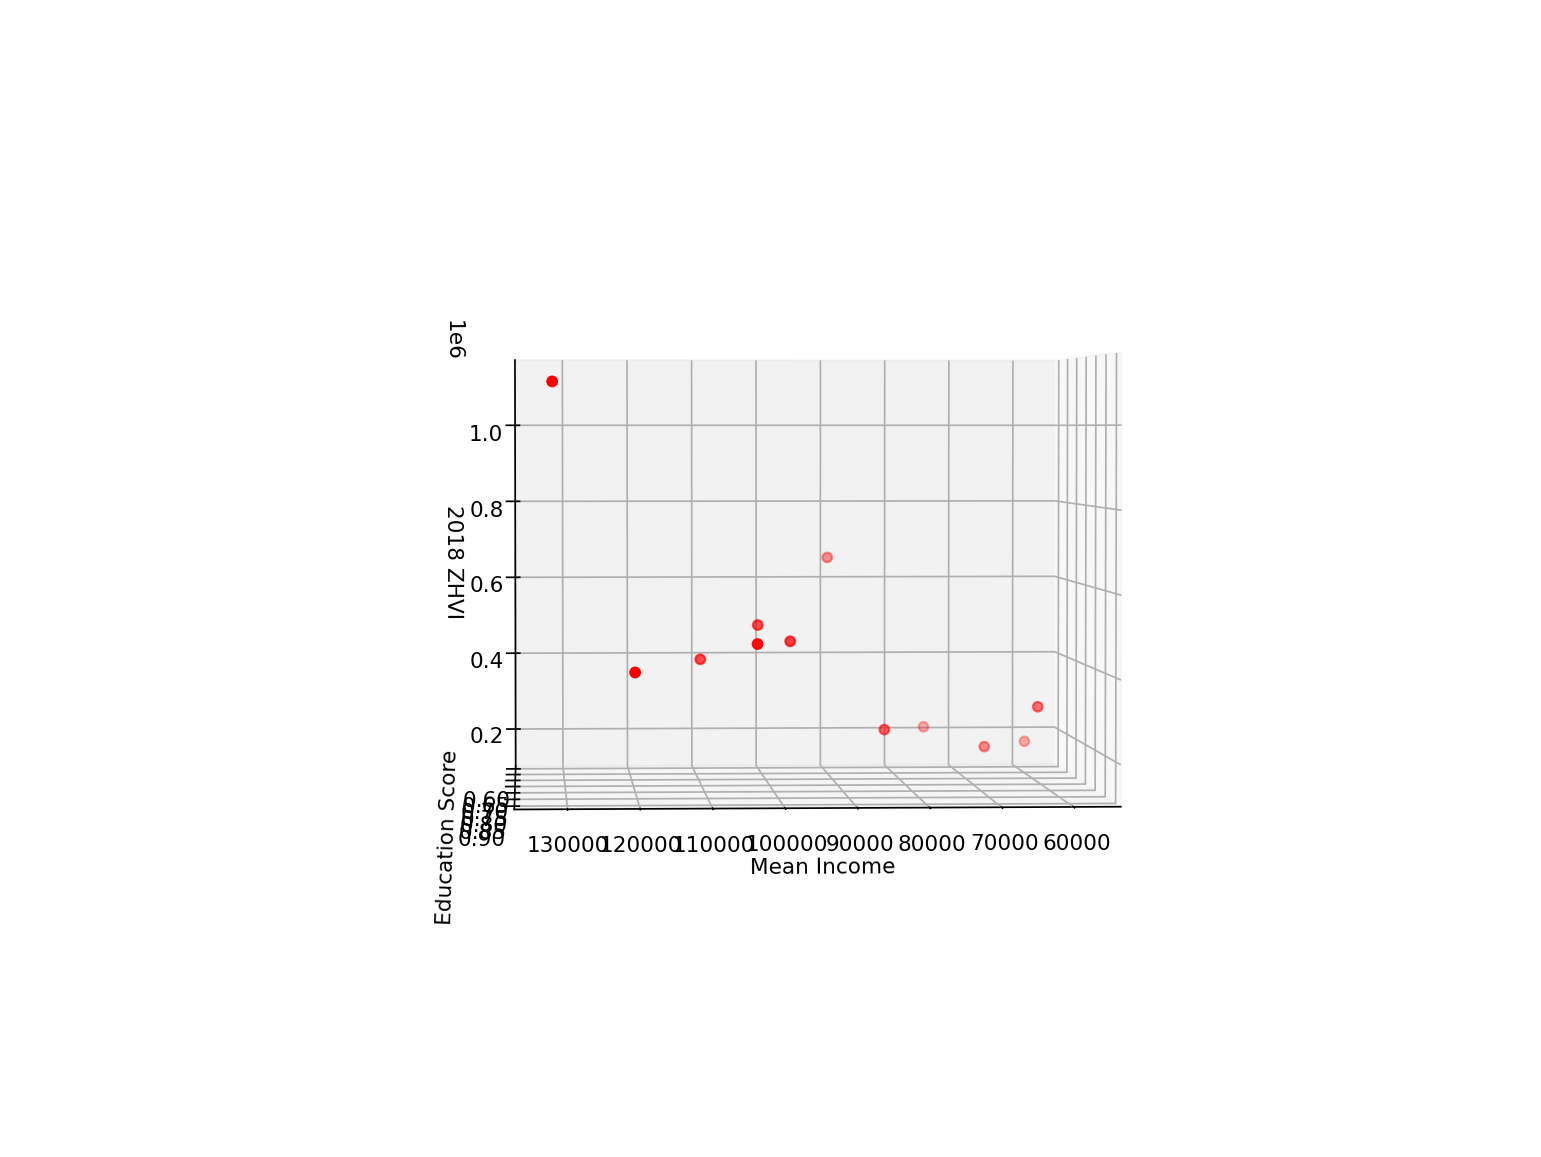

In [22]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(msazhvi['Mean Income'], msazhvi['Education Score'], msazhvi['2018 ZHVI'], c='r')
ax.set_xlabel('Mean Income')
ax.set_ylabel('Education Score')
ax.set_zlabel('2018 ZHVI')

plt.show()